# Training Notebook

This notebook contains the code for training the model on the MNIST dataset, evaluation can be found at [test.ipynb](https://github.com/ammar-elsabe/handwritten-digit-recognition-DCNN/blob/master/src/test.ipynb)

## Imports

For training the model, we need only tensorflow and tensorflow_datasets, which will be used to retrieve the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split
import itertools
from copy import deepcopy

## Loading the dataset
We use the [load](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method to load the mnist dataset

In [2]:
# Import the dataset mnist is 60k images of 28x28 pixels
# And 10k images for testing
(dstrain, dstest), dsinfo = tfds.load(
    'mnist',
    split=['train', 'test'],
    data_dir='../dataset/',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


2022-04-30 22:43:22.101616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 22:43:22.128722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 22:43:22.128874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 22:43:22.156073: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Print the image shape and class names

In [3]:
# Summarize loaded datasets
print('\nDataset info:')
print('Image shape:')
print(dsinfo.features['image'].shape)
print('Class Names')
print(dsinfo.features['label'].names)


Dataset info:
Image shape:
(28, 28, 1)
Class Names
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Visualize an image from the dataset

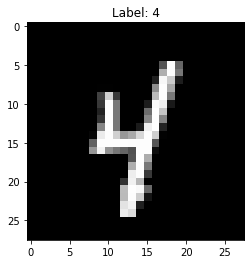

2022-04-30 22:43:28.205713: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
# Visualize a single image
def visualize_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title('Label: {}'.format(label))
    plt.show()


# Now use that function
mnist_example = dstrain.take(1)
for sample in mnist_example:
    image, label = sample[0], sample[1]
    visualize_image(image, label)
    break

Note that these wont be used, and that the dataset will be loaded multiple times with different splits in the experimentation

## Data pipeline
No preprocessing to the image data is going to be done, raw data is going to be inputted to the model directly, the data pipeline is only going to consist of batching the data into 128 images per batch, and applying an autotuned prefetch to make the fetching of the data faster

Note: instead of preprocessing the data right now, we have a resizing layer in the model architecture

From the Tensorflow Documentation:
> Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step `s`, the input pipeline is reading the data for step `s+1`. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

In [5]:
def trainpreprocess(dstrain, split, batch_size=128):

    dstrain = dstrain.batch(batch_size)
    dstrain = dstrain.cache()
    dstrain = dstrain.shuffle(dsinfo.splits['train+test[:' + split + ']'].num_examples)
    dstrain = dstrain.prefetch(tf.data.AUTOTUNE)
    return dstrain

We do the same for the testing set

In [6]:
def testpreprocess(dstest, batch_size=128):
    dstest = dstest.batch(batch_size)
    dstest = dstest.cache()
    dstest = dstest.prefetch(tf.data.AUTOTUNE)
    return dstest

## The Model

We then create the model architecture

In [7]:
def make_model(a):
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(a[0], activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(a[1], activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(a[2], activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

We do the experimentation using the adam optimizer, which is a version of stochastic gradient descent, and cross categorical cross entropy for the loss function which is mathematically written as:
$$
J(\textbf{w}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \text{log}(\hat{y}_i) + (1-y_i) \text{log}(1-\hat{y}_i) \right]
$$
We then build the model, and test it, saving along the way the accuracy value

In [ ]:
splits = ['60%', '70%', '80%']
hiddenlayerneurons = [p for p in itertools.product([60, 80, 100], repeat = 3)] # all perumations of 60, 80, 100, so (60,60,60), (60, 60, 80), .... ,(100, 100, 100)
i = 1
best_accuracy = 0
best_split = 0
best_neuron_counts = 0
best_iter = 1
accuracy = tf.keras.metrics.Accuracy()
allacc = []
model = None
for each_split in splits:
    for each_neuron_counts in hiddenlayerneurons:
        model_name = 'model_' + str(i)
        (dstrain, dstest), dsinfo = tfds.load(
            'mnist',
            split=['train+test[:' + each_split + ']', 'train+test[' + each_split + ':]'],
            data_dir='../dataset/',
            shuffle_files=True,
            as_supervised=True,
            with_info=True,
        )
        dstrain = trainpreprocess(dstrain, each_split)
        dstest = testpreprocess(dstest)
        model = make_model(each_neuron_counts)
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.build()
        history = model.fit(
            dstrain,
            epochs=30,
            validation_data=dstest,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=3
                    ,
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    model_name + '.h5',
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=1)
            ]
        )
        model = tf.keras.models.load_model('./' + model_name + '.h5')
        model_predictions = model.predict(dstest)
        predicted_labels = [np.argmax(x) for x in model_predictions]
        true_labels = np.concatenate([y for x, y in dstest], axis=0)
        # print(true_labels[:-10])
        # print(predicted_labels[:-10])
        accuracy.update_state(y_true = true_labels, y_pred = predicted_labels)
        curracc = accuracy.result().numpy()
        allacc.append({'test_split' : each_split, 'neuron_counts' : each_neuron_counts, 'accuracy' : curracc})
        print(allacc[-1])
        if(curracc > best_accuracy):
            best_accuracy = curracc
            best_split = each_split
            best_neuron_counts = each_neuron_counts
            best_iter = deepcopy(i)
        accuracy.reset_state()
        i += 1
print("best accuracy = {best_accuracy}, best split = {best_split}, best neuron counts = {best_neuron_counts}")


Save the table to a csv

In [23]:
import csv
keys = allacc[0].keys()
with open('models.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(allacc)

Load the best model and print its summary

In [24]:
model = tf.keras.models.load_model('./model_' + str(best_iter) + '.h5')
model.summary()

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_91 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 conv2d_182 (Conv2D)         (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d_182 (MaxPooli  (None, 13, 13, 28)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_455 (Ba  (None, 13, 13, 28)       112       
 tchNormalization)                                               
                                                                 
 conv2d_183 (Conv2D)         (None, 11, 11, 28)        7084      
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 5, 5, 28)       

Create the architecture diagram and save it to an svg

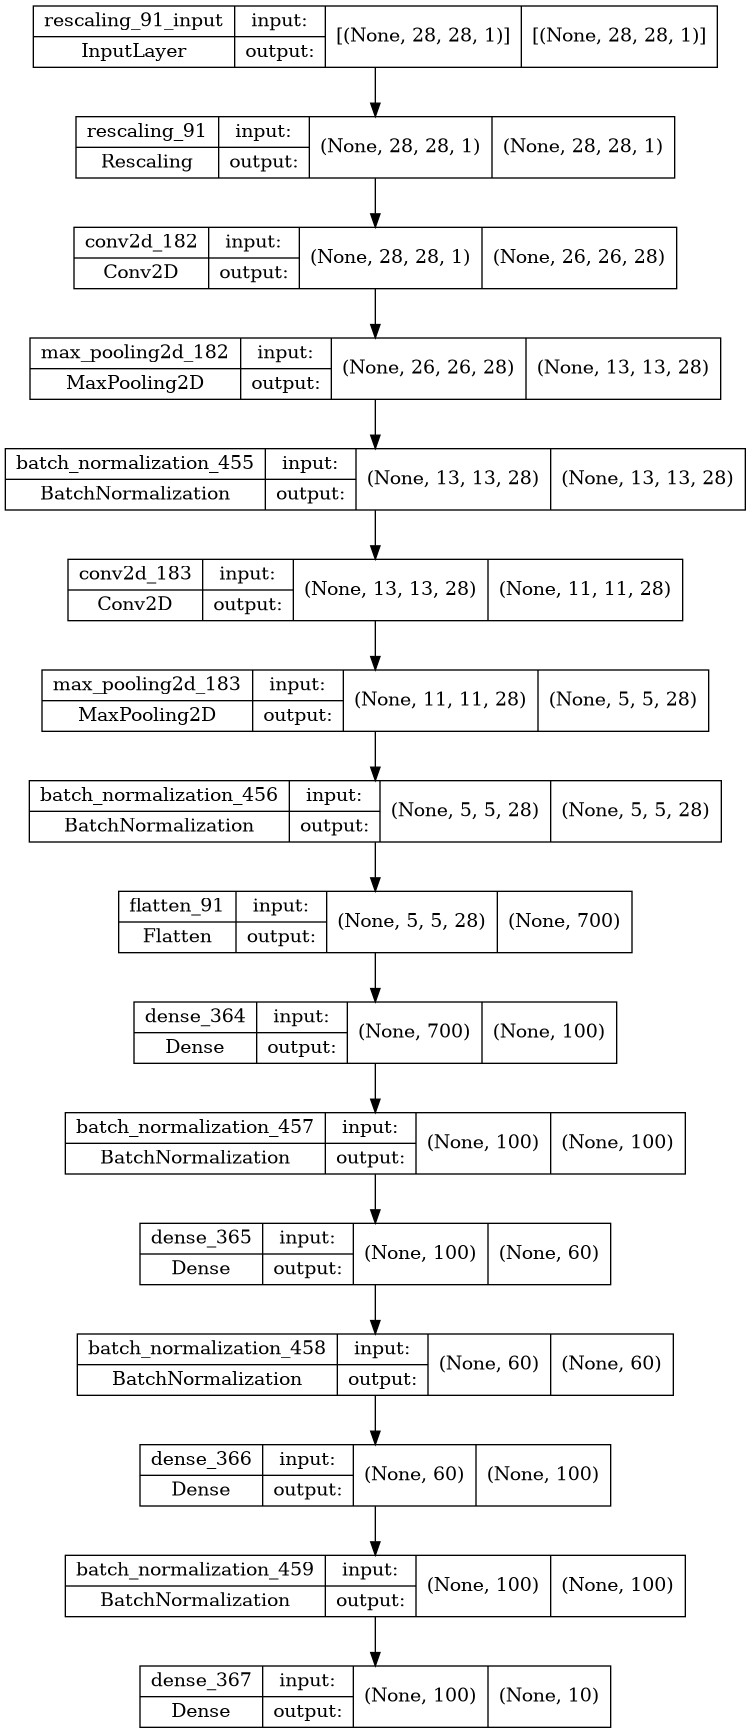

In [25]:
import pydot
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)


architecture = tf.keras.utils.model_to_dot(model, show_shapes = True)
view_pydot(architecture)
architecture.write_svg('../paper/figs/cnn_architecture.svg')

Save the model to `model.h5` so that we can load it again in the test script

In [26]:
model.save('./model.h5')

Plot the accuracies and the losses across the range of epochs

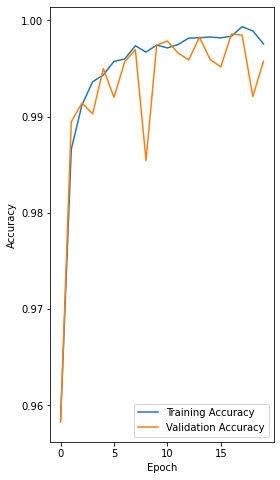

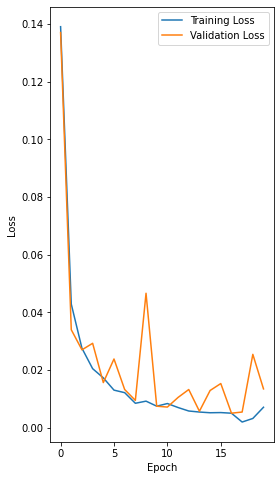

In [27]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(4, 8))
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig('../paper/figs/accuracy.svg', format='svg')
plt.show()

plt.figure(figsize=(4, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../paper/figs/loss.svg', format='svg')
plt.show()